# Transformer PyTorch implementation

## paper
Attention Is All You Need  
https://arxiv.org/pdf/1706.03762v5.pdf

## Transformer가 중요한 이유
- 근래 자연어처리 핵심 모델들은 Transformer의 구조를 기반으로 한 모델들임
- Transformer는 원래 기계 번역 Task를 수행하기 위해 제안된 모델이지만 해당 구조를 이용하여 다양한 Task에서 높은 성능을 보여줌
- Encoder, Decoder를 모두 포함한 모델임. 이후 자연어처리 모델들은 Transformer의 Encoder 부분을 떼어서 응용한 Bert 등의 Encoder 모델, Deocder 부분을 떼어서 응용한 GPT 등의 Decoder, 트랜스포머와 같이 Encoder, Deocder를 모두 사용하는 Encoder-Deocder 등으로 크게 구분할 수 있음
- Encoder 모델 예시 : Bert, RoBERTa, ALBERT, Electra 등
- Decoder 모델 예시 : GPT1, GPT2 등
- Encoder-Deocder 모델 예시 : BART, Longformer, T5, BigBird 등
- 과거 RNN, LSTM, GRU 등의 layer로 이루어진 모델들이 주류였던 딥러닝 자연어처리는 이후 Transformer 계열 모델들이 주류로 자리잡음 
- 때문에, 자연어처리에서 Transformer를 이해하는 것은 매우 중요함

## 선행 지식
 - Token Encoding, Tokenizer, Embedding에 대한 기본 개념 이해  
 - Attention, Attention Matrix에 대한 기본 개념 이해

# Transformer Structure

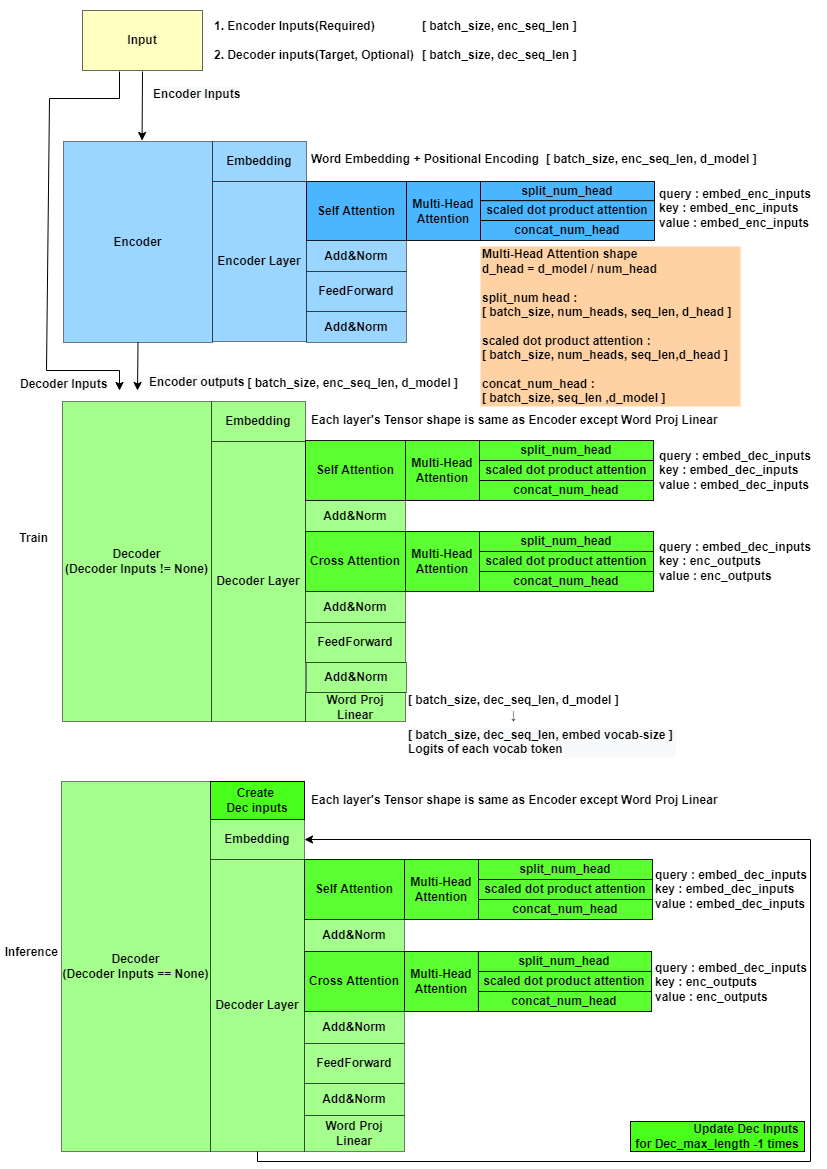

#### 본 내용에서는 토크나이저에 대해서는 별도로 다루지 않음

#### Token Encoding을 위해 Huggigface의 KoBigbird 모델의 Tokenizer 사용

In [ ]:
# Tokenizer 사용을 위한 라이브러리 설치
!pip install transformers==4.7

In [ ]:
from transformers import AutoTokenizer

import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [ ]:
# Tokenizer 정의
model_path = "monologg/kobigbird-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
# Config Class
# dict class를 json으로 바꿔서 confg.arg 와 같이 사용할 수 있게 만드는 class
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [ ]:
config_dict = {
    'vocab_size' : tokenizer.vocab_size,
    'd_model' : 128,
    'max_seq_len' : 64,
    'max_dec_len' : 48,
    'pad_id' : tokenizer.pad_token_id,
    'num_enc_layers' : 6,
    'num_dec_layers' : 6,
    'num_att_heads' : 4,
    'drop_out_raito' : 0.1,
    'feed_forward_dim' : 2048,
    'use_decoder' : True,
    'bos_id' : tokenizer.bos_token_id,
    'eos_id' : tokenizer.eos_token_id,
}

config = Config(config_dict)

# Positional Encoding

In [ ]:
def PositionalEncoding(max_seq_len, d_model):
    '''
    PE_(pos, 2i)   =  sin(pos / power(10000, 2i / d_model))
    PE_(pos, 2i+1) =  cos(pos / power(10000, 2i / d_model))
    '''
    pe = torch.zeros([max_seq_len, d_model])
    position = torch.arange(max_seq_len).unsqueeze(1).repeat(1, d_model) # pos, [seq_len, d_model]
    div_value = torch.pow(10000, torch.arange(0, d_model, 2) / d_model) # power(10000, 2i / d_model)
    pe[:, 0::2] = torch.sin(position[:, 0::2] / div_value) # sin for 2i
    pe[:, 1::2] = torch.cos(position[:, 1::2] / div_value) # cos for 2i+1
    pe = pe.unsqueeze(0) # [bs(1), seq_len, d_model]
    
    return 

In [ ]:
pe = PositionalEncoding(config.max_seq_len, config.d_model)

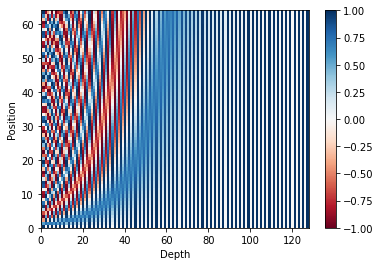

In [ ]:
plt.pcolormesh(pe[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, config.d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Input 데이터 정의

In [ ]:
def mk_dec_inputs(text, max_seq_len):
    input_ids = tokenizer.encode(text,max_length=max_seq_len, padding='max_length')
    cls_idx = input_ids.index(tokenizer.cls_token_id)
    sep_idx = input_ids.index(tokenizer.sep_token_id)

    input_ids[cls_idx] = tokenizer.bos_token_id
    input_ids[sep_idx] = tokenizer.eos_token_id

    return input_ids

enc_inputs = torch.tensor([tokenizer.encode('안녕하세요',max_length=config.max_seq_len, padding='max_length')]).expand(2,-1)
dec_inputs = torch.tensor([mk_dec_inputs('Hello', config.max_dec_len)]).expand(2,-1)

# Mask

In [ ]:
# mask for padding. shape of attention matrix. 
# it's used for encoder self attention, decoder self attention, decoder cross attention
def get_attn_pad_mask(key_inputs, pad_id, query_len):                   # self_attention : [bs, query_len, query_len]
    return key_inputs.eq(pad_id).unsqueeze(1).expand(-1, query_len, -1) # cross_attention : [bs, query_len, key_len]

In [ ]:
# Pad idx인 0의 위치만 True로 된 것 확인 가능
# 차원 자체는 pad mask는 attention matrix의 형태이므로 [bs, query_len, key_len]의 형태임
# self attention의 경우에는 query_len == key_len이지만 cross attention의 경우에는 query_len != key_len임

print(enc_inputs[0,:8])
print(get_attn_pad_mask(enc_inputs[0:1,:8], config.pad_id, 2)[0])

tensor([   2, 9279, 4681, 9421,    3,    0,    0,    0])
tensor([[False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True]])


In [ ]:
# decoder mask for the back of current positions. shape of attention matrix
# it's used for decoder self attention.
def get_subsequent_mask(inputs):
    subsequent_mask = torch.ones_like(inputs).unsqueeze(-1).expand(inputs.size(0), inputs.size(1), inputs.size(1)) # [bs, query_len, key_len]
    subsequent_mask = subsequent_mask.triu(diagonal=1) # like 0, 1, 1, 1...  subsequent_mask
    return subsequent_mask                             #      0, 0, 1, 1... 

In [ ]:
# 디코더의 순서대로 해당 위치 뒤의 부분도 참고하여 attention이 되지 않도록하는 mask
# row순서대로 mask위치가 한칸씩 변화하는 것을 확인할 수 있음
# encoder self attention의 attention mask는 pad_mask만 사용
# decoder self attention의 attention mask는 pad_mask + subsequent_mask의 형태임
# decoder cross attention의 attention mask도 pad mask만을 사용. 단 이때는 self attention과 달리 input이 query=key=value가 아니라 query!=key==value의 형태이기 때문에 attention matrix의 형태가 self attention과 다름
print(dec_inputs[0,:8])
print(get_subsequent_mask(dec_inputs[0:1,:8]))

tensor([    5, 17920, 18520,  4508,     6,     0,     0,     0])
tensor([[[0, 1, 1, 1, 1, 1, 1, 1],
         [0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 0]]])


# Multi-Head Attention

Encoder의 self attention, Decoder의 self attention, cross attention은 모두 해당 class를 사용하고 동일합 입력, 출력 형태를 보이지만 각각 입력값이 다름

## Encoder
- Self Attention
  - mask : pad mask
  - self attention이므로 query==key==value, query= embedded encoder input

## Deoceder
- Self Attention
  - mask : pad mask + subsequent mask
  - self attention이므로 input이 query == key == value, query= embedded decoder input

- Cross Attention
  - mask : pad mask
  - cross attention이므로 input이 query != key == value, query = embedded decoder input, key, value = encoder output 임

위와 같은 차이가 있지만 아래에서 정의한 하나의 Class의 각각에 대응하는 값을 입력하여 모든 Attention을 수행함

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super(MultiHeadAttention, self).__init__()
        self.d_model = config.d_model
        self.num_att_heads = config.num_att_heads
        assert self.d_model % self.num_att_heads == 0, "d_model({}) % num_att_heads({}) = {}. It should be 0.".format(self.d_model, self.num_att_heads, self.d_model % self.num_att_heads)
        
        self.d_head = int(self.d_model / self.num_att_heads)
        
        self.query_proj = nn.Linear(self.d_model, self.num_att_heads * self.d_head)
        self.key_proj = nn.Linear(self.d_model, self.num_att_heads * self.d_head)
        self.value_proj = nn.Linear(self.d_model, self.num_att_heads * self.d_head)

        self.scaled_dot_attn = ScaledDotProductAttention(config, self.d_head)
        self.linear = nn.Linear(self.d_head * self.num_att_heads, self.d_model)

    def forward(self, query, key, value, attn_mask):
        batch_size = query.size(0)

        query = self.query_proj(query).view(batch_size, -1, self.num_att_heads, self.d_head).transpose(1,2) # [bs, num_heads, query_len, d_head]
        key = self.key_proj(key).view(batch_size, -1, self.num_att_heads, self.d_head).transpose(1,2) # [bs, num_heads, key_len, d_head]
        value = self.value_proj(value).view(batch_size, -1, self.num_att_heads, self.d_head).transpose(1,2) # [bs, num_heads, value_len, d_head]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.num_att_heads, 1, 1) # [bs, query_len, key_len] -> [bs, num_heads, query_len, key_len]

        context, attn_prob = self.scaled_dot_attn(query, key, value, attn_mask)

        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.num_att_heads * self.d_head)
        
        output = self.linear(context)
        
        return output, attn_prob

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config, d_head):
        super(ScaledDotProductAttention, self).__init__()
        self.config = config
        self.scale = d_head ** 0.5

    def forward(self, query, key, value, attn_mask):

        scores = torch.matmul(query, key.transpose(-2, -1)) / self.scale # [bs, num_heads, query_len, key_len]
        
        scores.masked_fill_(attn_mask, -1e4)
        
        attn_prob = nn.Softmax(dim=-1)(scores)
        # 성능 관련 실험 필요. 허깅페이스에서는 dropout 사용함
        # attn_prob = nn.Dropout(self.config.drop_out_raito)(attn_prob)
        context = torch.matmul(attn_prob, value) # [bs, num_heads, query_len, d_head]
                                                  
        return context, attn_prob

# Posistion-Wise Feed-Forward

In [ ]:
class PoswiseFeedForward(nn.Module):
    def __init__(self, config):
        super(PoswiseFeedForward, self).__init__()      

        self.feed_forward = nn.Sequential(nn.Linear(config.d_model, config.feed_forward_dim),
                                          nn.Dropout(config.drop_out_raito),
                                          nn.ReLU(),
                                          nn.Linear(config.feed_forward_dim, config.d_model),
                                          nn.Dropout(config.drop_out_raito))

    def forward(self, inputs):
        return self.feed_forward(inputs)

# Add&Norm

In [ ]:
class AddNorm(nn.Module):
    def __init__(self, layer, d_model):
        super(AddNorm, self).__init__()
        self.layer = layer
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, *args):
        residual = args[0]
        output = self.layer(*args)

        if isinstance(output, tuple):
            return self.layer_norm(output[0] + residual), output[1]
        else:
            return self.layer_norm(output + residual)

# Encoder

Encoder의 경우 아래와 같은 비교적 단순한 구조를 가짐

a) embeddding   
b) self attention   
c) add&norm   
d) feed_forward   
e) add&norm   
f) output   

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super(TransformerEncoder, self).__init__()
        self.config = config
        self.word_embedding = nn.Embedding(config.vocab_size, config.d_model, padding_idx=config.pad_id)
        self.sqrt_dim = math.sqrt(config.d_model)
        self.pos_encoding = PositionalEncoding(config.max_enc_len, config.d_model)

        self.layers = nn.ModuleList(
            [TransformerEncoderLayer(config) for _ in range(config.num_enc_layers)]
        )

    def forward(self, enc_inputs, self_attn_mask=None):
        outputs = self.word_embedding(enc_inputs) * self.sqrt_dim + self.pos_encoding.to(enc_inputs.device)

        if self_attn_mask == None:
            self_attn_mask = get_attn_pad_mask(enc_inputs, self.config.pad_id, enc_inputs.size(1))
            
        else:
            self_attn_mask = get_attn_pad_mask(self_attn_mask, 0, self_attn_mask.size(1))

        self_attn_probs = []
        for layer in self.layers:
            outputs, self_attn_prob = layer(outputs, self_attn_mask)
            self_attn_probs.append(self_attn_prob)
        
        return outputs, self_attn_probs

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attention = AddNorm(MultiHeadAttention(config), config.d_model)
        self.feed_forward = AddNorm(PoswiseFeedForward(config), config.d_model)

    def forward(self, inputs, self_attn_mask):
        outputs, self_attn_prob = self.self_attention(inputs, inputs, inputs, self_attn_mask)
        outputs = self.feed_forward(outputs)
        return outputs, self_attn_prob

# Decoder

Decoder의 경우 상대적으로 더 복잡한 구조를 가짐

우선, encoder inputs가 항상 주어지는 encoder와 달리 deocder inputs(label)가 주어지는 train 상황과 inference 상황을 나누어서 고려를 해야함

train과 inference 모두 같은 구조를 적용하는 코드도 있지만,
여기서는 참고한 Soohwan님의 코드와 같이 train과 inference시의 코드 구조를 다르게 적용
(https://github.com/sooftware/transformer)

이 방식을 사용할 경우 eos토큰이 나올 때까지 deocder 길이만큼 모델 추론을 반복할 필요 없이 decoder 부분만 추가 연산을 진행함으로 encoder의 중복 연산을 피할 수 있다는 장점이 있음. 때문에 encoder inputs 길이에 비해 decoder outputs의 길이가 짧을 때 특히 효율적일 수 있음

하지만 eos를 기준으로 추론을 종료하지 않기 때문에 max_decoder_len과 평균적인 decoder outputs의 eos 토큰의 decoder index의 차이가 큰 경우, decoder에 비해 encoder inputs 길이가 상대적으로 짧은 경우에는 단점으로 작용될 수 있음

## Train의 경우
a) embeddding   
b) self attention   
c) add&norm   
d) cross attention   
e) add&norm   
f) feed_forward   
g) add&norm   
h) word_proj_linear(embedding vocab 수)   
i) outputs

## Inference의 경우
a) decoder inputs 생성   
b) embeddding   
c) self attention   
d) add&norm   
e) cross attention   
f) add&norm   
g) feed_forward   
h) add&norm    
i) word_proj_linear(embedding vocab 수)   
j) decoder max len까지 b) - i) 과정 반복, decoder inputs 업데이트   
k) outputs   

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, config):
        super(TransformerDecoder, self).__init__()
        self.config = config
        self.word_embedding = nn.Embedding(config.vocab_size, config.d_model, padding_idx=config.pad_id)
        self.sqrt_dim = math.sqrt(config.d_model)
        self.pos_encoding = PositionalEncoding(config.max_dec_len, config.d_model)

        self.layers = nn.ModuleList(
            [TransformerDecoderLayer(config) for _ in range(config.num_dec_layers)]
        )

        self.fc = nn.Linear(config.d_model, config.vocab_size)

    def decoder_step(self,
                     dec_inputs,
                     enc_outputs,
                     enc_inputs):

        dec_outputs = self.word_embedding(dec_inputs) * self.sqrt_dim + self.pos_encoding[:, :dec_inputs.size(1)].to(dec_inputs.device)

        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, self.config.pad_id, dec_inputs.size(1))
        dec_self_attn_subsequent_mask = get_subsequent_mask(dec_inputs)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        dec_cross_attn_mask = get_attn_pad_mask(enc_inputs, self.config.pad_id, dec_inputs.size(1))

        self_attn_probs, cross_attn_probs = [], []
        for layer in self.layers:
            dec_outputs, self_attn_prob, cross_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_cross_attn_mask)
            self_attn_probs.append(self_attn_prob)
            cross_attn_probs.append(cross_attn_prob)

        return dec_outputs, self_attn_probs, cross_attn_probs

    def forward(self,
                dec_inputs,
                enc_outputs,
                enc_inputs):
       

        if dec_inputs is not None:
            dec_outputs, self_attn_probs, cross_attn_probs = self.decoder_step(dec_inputs=dec_inputs,
                                                                               enc_outputs=enc_outputs,
                                                                               enc_inputs=enc_inputs)
            dec_outputs = self.fc(dec_outputs)

        else:
            dec_inputs = torch.zeros([enc_outputs.size(0), self.config.max_dec_len], device=enc_outputs.device).long()
            dec_inputs = dec_inputs.fill_(self.config.pad_id)
            dec_inputs[:, 0] = self.config.bos_id

            dec_outputs = []
            for dec_idx in range(1, self.config.max_dec_len):
                dec_output, self_attn_probs, cross_attn_probs = self.decoder_step(dec_inputs=dec_inputs[:, :dec_idx],
                                                                                  enc_outputs=enc_outputs,
                                                                                  enc_inputs=enc_inputs)
                dec_output = self.fc(dec_output)                
                dec_outputs.append(dec_output[:, -1, :])                
                dec_inputs[:, dec_idx] = dec_outputs[-1].argmax(dim=-1)
                
            dec_outputs = torch.stack(dec_outputs, dim=1)


        return dec_outputs, self_attn_probs, cross_attn_probs

In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, config):
        super(TransformerDecoderLayer, self).__init__()

        self.self_attention = AddNorm(MultiHeadAttention(config), config.d_model)
        self.cross_attention = AddNorm(MultiHeadAttention(config), config.d_model)
        
        self.feed_forward = AddNorm(PoswiseFeedForward(config), config.d_model)

    def forward(self, dec_inputs, enc_outputs, self_attn_mask, cross_attn_mask):
        
        outputs, self_attn_prob = self.self_attention(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        outputs, cross_attn_prob = self.cross_attention(outputs, enc_outputs, enc_outputs, cross_attn_mask)
        outputs = self.feed_forward(outputs)
        
        return outputs, self_attn_prob, cross_attn_prob

# Transformer Model

Transformer Model은 위에서 정의한 Encoder, Deocder를 이용하여 간단하게 정의 가능

In [ ]:
class Transformer(nn.Module):
    def __init__(self, config):
        super(Transformer, self).__init__()
        self.config = config
        self.encoder = TransformerEncoder(config)
        if config.use_decoder == True:
            self.decoder = TransformerDecoder(config)
        
        self.init_weights()

    def init_weights(self):
        # Initialize weights for each layer
        self.apply(self.init_layer_weights)

    # ref huggingface
    # https://huggingface.co/transformers/v4.9.2/_modules/transformers/models/electra/modeling_electra.html#ElectraPreTrainedModel
    def init_layer_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.init_std)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.init_std)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
            module.eps = self.config.norm_eps

    def forward(self, 
                enc_inputs, 
                dec_inputs=None, 
                enc_self_attn_mask=None,
                dec_self_attn_mask=None,
                dec_cross_attn_mask=None):
        
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs, enc_self_attn_mask)
        
        if self.config.use_decoder == False:
            return enc_outputs, enc_self_attn_probs
        
        dec_outputs, dec_self_attn_probs, dec_cross_attn_probs = self.decoder(dec_inputs,
                                                                              enc_outputs, 
                                                                              enc_inputs)
        
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_cross_attn_probs

# Test

In [ ]:
config

{'vocab_size': 32500,
 'd_model': 128,
 'max_seq_len': 64,
 'max_dec_len': 48,
 'pad_id': 0,
 'num_enc_layers': 6,
 'num_dec_layers': 6,
 'num_att_heads': 4,
 'drop_out_raito': 0.1,
 'feed_forward_dim': 2048,
 'use_decoder': True,
 'bos_id': 5,
 'eos_id': 6}

In [ ]:
config.use_decoder = False

In [ ]:
model = Transformer(config)

In [ ]:
result = model(enc_inputs)

In [ ]:
result.keys()

dict_keys(['encoder_hidden_states', 'encoder_self_attention_prob'])

In [ ]:
result['encoder_hidden_states'].shape

torch.Size([2, 64, 128])

In [ ]:
config.use_decoder = True

In [ ]:
model = Transformer(config)

In [ ]:
result = model(enc_inputs, dec_inputs)

In [ ]:
result.keys()

dict_keys(['decoder_hidden_states', 'encoder_self_attention_prob', 'decoder_self_attention_prob', 'decoder_cross_attention_prob'])

In [ ]:
result['decoder_hidden_states'].shape

torch.Size([2, 48, 32500])

In [ ]:
result = model(enc_inputs)

In [ ]:
result['decoder_hidden_states'].shape

torch.Size([2, 47, 32500])

In [ ]:
model = Transformer(config).to('cuda')
enc_inputs = enc_inputs.to('cuda')

result = model(enc_inputs)